In [1]:
"""
@author: SergioSJS - Sérgio José de Sousa
@email: sergio7sjs@gmail.com
Machine Learning Discipline Work
UFMG - Teacher: Adriano Veloso

Create and analyze the AdaBoost method using cross-validation to split the dataset
"""
import numpy as np
import time
import matplotlib.pyplot as plt
from random import seed, randrange

In [2]:
def replace(data, dic):
    """Replace the data with a dictionary
    
    Keyword arguments:
    data -- List of lists data
    dic -- The values to change
    return -- Changed data
    """
    ndata = np.zeros(data.shape)
    for r, row in enumerate(data):
        for c, col in enumerate(row):
            ndata[r, c] = dic.get(col)
    return ndata

def print_tic_tac_toe(tup):
    """Print Tic Tac Toe play
    
    Keyword arguments:
    tup -- list of value with 9 values
    return -- print 3x3
    """
    line = ''
    for l, it in enumerate(tup):
        line = line + ' ' + it
        if (l+1) % 3 == 0:
            print line
            line = ''
        
def kfold(data, folds=5):
    """Make a k-fold to cross validation data returning a separate list of index.
    
    Keyword arguments:
    data -- data with labels of data
    folds -- numer of folds(default 5)
    return -- the splitted INDEX data, iterating k-fold times
    """
    data_splitted = list()
    data_copy = list(range(len(data)))
    fold_size = int(len(data)/folds)
    # split data in folds
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(data_copy))
            fold.append(data_copy.pop(index))
        data_splitted.append(fold)
    
    # create the iterable return
    for i in range(folds):
        test_list = list()
        train_list = list()
        train_temp = list()
        
        rangeF = range(folds)
        rangeF.pop(i)
        for i2 in rangeF:
            train_temp.append(data_splitted[i2])
            
        train_list.append([y for x in train_temp for y in x])
        test_list.append(data_splitted[i]) 
    
        yield train_list, test_list
        
def get_values(dic, field):
    """In a list of dictionaries, return all values of some field
    
    Keyword arguments:
    dic -- list of dictionaries
    field -- field to return
    return -- list of values
    """
    value_list = []
    for t in dic:
        value_list.append(t[field])
        
    return value_list

def save_dictionary(dic, file_name='result.npy'):
    """Save the dictionary in a file
    
    Keyword arguments:
    dic -- dictionary to save
    file_name -- path with name of file (default result.npy)
    """
    np.save(file_name, adaboost_tests) 

def load_dictionary(file_name='result.npy'):
    """Load the dictionary from a file
    
    Keyword arguments:
    file_name -- path with name of file (default result.npy)
    """
    return np.load(file_name).item()

In [3]:
# Load data
dataset = np.loadtxt('tic-tac-toe.data', delimiter=',', dtype=str)
xData = dataset[:,0:-1]
yData = dataset[:,-1:]

# Dictionaries to replace values of dataset
dicX = {'o': 0.0, 'x' : 1.0, 'b' : -1.0}
dicY = {'negative' : -1, 'positive' : 1}

# Replace the values, x = 1, o = 0, b = -1, positive = 1, negative = -1
n_xData = replace(xData, dicX)
n_yData = replace(yData, dicY)

In [4]:
class DecisionStump():
    """Class to generate the weak classification Decision Stump
    """
    def __init__(self, xData, yData):
        """Initializete the model
        
        Keyword arguments:
        xData -- Data to generate the model
        yData -- Labels to validate the model
        """
        self.xData = np.array(xData)
        self.yData = np.array(yData)     
        self.Qtd = self.xData.shape[1] # amount of data
        
    def stump_train(self, W, steps=3, verbose=0):
        """Train the Model
        
        Keyword arguments:
        W -- weight of the data
        steps -- Number of possible steps to find a separator data
        verbose -- print or not the evaluation
        """
        minErr = float('inf')
        _value = 0
        _att = 0
        _label = 0
        self.W = np.array(W)
        
        for att in range(self.Qtd):
            value, err = self._best_stump(att, steps, 1)
            if (err < minErr):
                minErr = err
                _value = value
                _att = att
                _label = 1
        for it in range(self.Qtd):
            value, err = self._best_stump(att, steps, -1)
            if (err < minErr):
                minErr = err
                _value = value
                _att = att
                _label = -1
        
        self.value = _value
        self.att = _att
        self.label = _label
        
        if verbose == 1:
            print ('att.:',_att,'- value:',_value,'- label:',_label, '- minErr:', minErr)
        
        return minErr
            
    def _best_stump(self, att, steps, label):
        """Select the best stump model
        
        Keyword arguments:
        att -- attribute tested in stump
        steps -- through the lowest value, the highest value and steps finds best option to stump
        label -- label tested
        return -- _value -- value tested
        return -- _minErr -- error of best stump
        """
        limite_up = np.max(self.xData[:, att])+1
        limite_bottom = np.min(self.xData[:, att])
        interval = (limite_up-limite_bottom)/steps
        
        _value = 0
        _minErr = float('inf')
        # for each possible value
        for value in np.arange(limite_bottom, limite_up, interval):
            # This code only considerate categorical data
            predict = self._predict_categorical_train(att, value, label)
            
            err = 0
            # Calculate the error using the weights
            for i, d in enumerate(self.yData):
                err += (predict[i] != d) * self.W[i]
                
            if err < _minErr:
                _minErr = err
                _value = value
        return _value, _minErr
            
    def _predict_categorical_train(self, att, value, label):
        """During the train, predict the using the best model
        
        Keyword arguments:
        att -- attribute tested
        value -- value tested
        label -- label tested
        return -- predict list of each train sample
        """
        predict = np.zeros(self.yData.shape)
        for id, x in enumerate(self.xData[:,att]):
            if x == value:
                predict[id] = 1*label
            else:
                predict[id] = -1*label       
        return predict
    
    def predict_categorical(self, xTest):
        """Predict function to external analyzes 
        
        Keyword arguments:
        xTest -- dataset to predict
        return -- predict list
        """
        xTest=np.array(xTest)
        predict = np.zeros(xTest.shape[0])
        for id, x in enumerate(xTest[:,self.att]):
            if x == self.value:
                predict[id] = 1*self.label
            else:
                predict[id] = -1*self.label       
        return predict
            

In [5]:
class AdaBoost():
    """AdaBoost class
    """
    def __init__(self, xData, yData):
        """Initializate adabost method
        
        Keyword arguments:
        xData -- dataset to train the models
        yData -- label list to validate the models
        """
        self.xData = np.array(xData)
        self.yData = np.array(yData)
        # Initialize weights 
        self.W = np.ones((self.xData.shape[0],1)).flatten()/self.xData.shape[0]

        self.dStump = DecisionStump
        self.lastError = 0.0
    
    def train(self, M=5, verbose=0):
        """Train adaboost
        
        Keyword arguments:
        M -- number of weak models
        verbose -- print or not the evaluation
        """
        self.alpha = {} #dictionary with alphas
        self.models = {} #dictionary with models
        self.verbose = verbose
        
        for i in range(M):
            # select and add the best decision stump
            self.models[i] = self.dStump(self.xData, self.yData)
            # calculate the error of the decision stump
            self.lastError = self.models[i].stump_train(self.W, verbose = verbose)
            e = self.lastError
            # calculate the alpha of the model
            self.alpha[i] = (1/2.)*np.log((1-e)/e)
            # use the decision stump to predict
            res = self.models[i].predict_categorical(self.xData)
            # calculate the new weights of the data
            Wz = self.W*np.exp(-self.alpha[i]*self.yData.flatten()*res.flatten())
            # normalizate the weights
            self.W = (Wz/Wz.sum()).flatten()
    
    def predict(self, testX):
        """Method to predict the data
        
        Keyword arguments:
        testX -- dataset to predicting
        return -- predicted list
        """
        testX = np.array(testX)
        sums=np.zeros(testX.shape[0])
        # for each model performs the sum of the results by multiplying by alpha
        for i in range(len(self.models)):
            sums = sums+self.models[i].predict_categorical(testX).flatten()*self.alpha[i]
        
        # considerate only sign of the result
        prev_y=np.zeros(np.array(sums).shape)
        prev_y[sums>=0]=1
        prev_y[sums<0]=-1
        
        return prev_y    

In [55]:
def run(nModels, folds=5, verbose=0):
    """Initialize the process
    
    Keyword arguments:
    nModels -- number of weak models
    folds -- number of k-fold cross-validation
    verbose -- if print results
    return -- dictionary with the results
    """
    ada_result = {}
    train_scores = []
    train_errors = []
    test_errors = []
    test_scores = []
    last_model_error = []

    ctFold = 0

    start = time.time()
    # Perform cross-validation
    for train, test in kfold(n_yData, folds=folds):
        print("n_models = {0} - k-fold {1}/{2}                \r".format(nModels, ctFold+1, folds)),
        ada = AdaBoost(n_xData[train], n_yData[train])
        ada.train(nModels, verbose = 0)
        # The last model error
        last_model_error.append(ada.lastError)
        
        # Calculate the train error
        predict_train = ada.predict(n_xData[train])
        err = 0.
        acc = 0.
        for i, sample in enumerate(n_yData[train]):
            if sample == predict_train[i]:
                acc += 1
            else:
                err += 1
            train_scores.append((acc/(acc+err)))
            train_errors.append((err/(acc+err)))
        
        # Calculate the test error
        predict_test = ada.predict(n_xData[test])
        err = 0.
        acc = 0.
        for i, sample in enumerate(n_yData[test]):
            if sample == predict_test[i]:
                acc += 1
            else:
                err += 1
            test_scores.append((acc/(acc+err)))
            test_errors.append((err/(acc+err)))

        ctFold += 1

    end = time.time()
    
    #Store the results in a dictionary
    ada_result['n_models'] = nModels
    
    ada_result['train_score'] = np.mean(train_scores)
    ada_result['train_score_std'] = np.std(train_scores)
    ada_result['train_errors'] = np.mean(train_errors)
    ada_result['train_errors_std'] = np.std(train_errors)
    
    ada_result['test_score'] = np.mean(test_scores)
    ada_result['test_score_std'] = np.std(test_scores)
    ada_result['test_errors'] = np.mean(test_errors)
    ada_result['test_errors_std'] = np.std(test_errors)
    
    ada_result['last_model_error'] = np.mean(last_model_error)
    ada_result['last_model_error_std'] = np.std(last_model_error)
    
    ada_result['time'] = (end - start)
    
    if verbose == 1:
        print("Number Models   %.0f" % (nModels))
        print("Train Hits      %.4f (+/- %.4f)" % (np.mean(train_scores), np.std(train_scores)))
        print("Train Errors    %.4f (+/- %.4f)" % (np.mean(train_errors), np.std(train_errors)))
        print("Test Hits       %.4f (+/- %.4f)" % (np.mean(test_scores), np.std(test_scores)))
        print("Test Errors     %.4f (+/- %.4f)" % (np.mean(test_errors), np.std(test_errors)))
        print("Last Weak Model %.4f (+/- %.4f)" % (np.mean(last_model_error), np.std(last_model_error)))
        print("Time            %.4f (s)" % (end - start))
        
    return ada_result

def plot_error_report(adaboost_tests):
    """Plot the error result of the models
    
    Keyword arguments:
    adaboost_tests -- dictionary with the data
    """
    fig = plt.figure()

    plt.title("AdaBoost")
    nX = get_values(adaboost_tests.values(), 'n_models')
    plt.plot(nX, get_values(adaboost_tests.values(), 'test_errors'), label='test error')
    plt.plot(nX, get_values(adaboost_tests.values(), 'train_errors'), label='train error')
    plt.plot(nX, get_values(adaboost_tests.values(), 'last_model_error'), label='weak learner weighted trainning')

    plt.ylabel("Error rate")
    plt.xlabel("Number of weak learners")

    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 1.5, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

<a id='test1'></a>

Total Time 72.9400 (s)                    


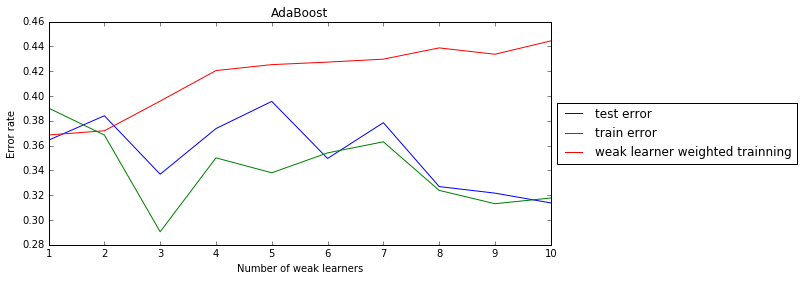

In [57]:
"""
Realize the train and test with up to 10 models
"""
seed(1) # seed for a random values
max_n_models = 10 # number max of weak models in adaboost
adaboost_tests = {} # results
start = time.time() # total time

for n in range(1, max_n_models+1):
    adaboost_tests[n] = run(nModels = n, folds = 5)
    
end = time.time()
print("Total Time %.4f (s)               " % (end - start))

save_dictionary(adaboost_tests, file_name='result10.npy')
plot_error_report(adaboost_tests)

<a id='test10'></a>

Total Time 9037.2947 (s)                    


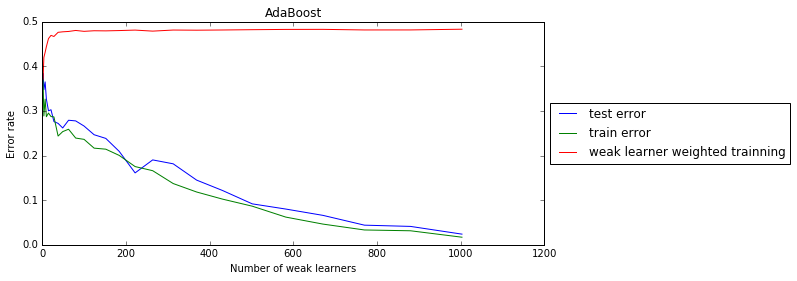

In [64]:
"""
Realize the train and test with growing quantities of wake models with the form: round((n*2)**np.log10(n*2))
qtd:n_models = 1:1, 2:2, 3:4 4:7 5:10 6:15 7:21 8:28 9:38 10:49 
"""
seed(1) # seed for a random values
qtd = 27 # number of times with growing quantities of weak models
adaboost_tests = {} # results
start = time.time() # total time

for n in range(1, qtd+1):
    nModels = int(round((n*2)**np.log10(n*2)))
    adaboost_tests[n] = run(nModels = nModels, folds = 5)
    
end = time.time()
print("Total Time %.4f (s)               " % (end - start))

save_dictionary(adaboost_tests, file_name='result1003.npy')
plot_error_report(adaboost_tests)

<h1>Report</h1>

<div>To test this code enough call the function run() passing as an argument the number of weak models<br/>
<i>Ex.: run(nModels = 10)</i><br/>
This will return a dictionary with the results</div>
<br/>

This simple model have just one hyperparameter, the number of the weak models, so, how the greater the quantity, better is the model or better rule. The algorithm automatically verify and select the best rules with the best accuracy. After that, realizes avaliation of the alpha, fallowed by change the weights of the data, increasing the weights of wrong classified data. This process repeat until the hyperparameter value. A important observation, how after each rule the data distribuction change, the algorithm can be select the same rules but with different values of alpha and weights.

[Hire](#test1) We have a simple test with increasing number of model from 1 to 10. Through the mean of the cross validation method we can evaluate the results more accurately. Although it oscilates, we can see that both the test and train error are decreasing.

As we increase the number of models the error value decreases less and less. In this case, adaboost with 500 models and with 501 models has very close error. So we create a function to give a growing value, resultin in 28 Adaboosts (1, 2, 4, 7, 10, 15, 21, 28, 38, 49, 63, 80, 100, 124, 152, 184, 222, 264, 313, 369, 431, 502, 582, 671, 770, 880, 1003). The result can see [hire](#test10). The test error almost always bigger than train error but both tending to zero. While the error of the worst model within that adaboost tends to increase as can be seen by the red line in the graph.

On Mean, the AdaBoost got the following hit rate for weak model quantities below. 

* 10 = score 0.6852
* 100 = score 0.7463
* 200 = score 0.8037
* 500 = score 0.9039
* 1000 = score 0.9780
* 1500 = score 0.9832

A important observation, adaboost can't overfitting, proving to be an important and useful method with low train and test error.